# Бинарная модель востребованности контента и ее вероятностный прогноз

В бинарном классификаторе kNN работает голосование: каких соседей больше, к такому классу и будет отнесен объект. То есть, если вычислить вероятность принадлежности к класу, то сам класс получается бинаризацией вероятности по порогу 0.5.

Мы хотим выяснить, сможем ли мы услить бинарный классификатор, если будем возвращать не класс, а вероятность принадлежности к классу, после чего подберем порог бинаризации вероятности, который дает наибольшую метрику прогнозирующей эффективности, не отриентируясь на дефолтное значение 0.5. И сильно ли при этом будет отличаться оптимальный порог бинаризации от дефолтного.

В качестве данных использовались данные о потребление контента на одном из каналов оного из видеохостингов. Подробнее об этом исследовании можно прочитать в pdf-файле этого репозитория.

## Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.neighbors as skln
import sklearn.metrics as sklm
import sklearn.model_selection

## Чтение данных

Читаем данные из файла csv. Потом смотрим инфу и описания. Описания идут отдельно для числовых и нечисловых данных.

In [2]:
df = pd.read_csv('data/data.csv')
df

,Клики по элементам конечной заставки,Показы элементов конечной заставки,Показы тизеров,Постоянные зрители,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,Средний процент просмотра (%),Отказались от подписки,Новые подписчики,Новые комментарии,Поделились,"Отметки ""Не нравится""","Отметки ""Нравится""",Просмотры,Время просмотра (часы),Показы,CTR для значков видео (%),Доля подписок
0,9.0,792.0,54.0,325.0,1100.0,1.2833,1465.0,23.93,1.0,8.0,1.0,17.0,4.0,40.0,1880.0,90.9871,8889.0,14.77,Высокая
1,7.0,467.0,56.0,211.0,585.0,1.2736,815.0,28.95,0.0,6.0,1.0,10.0,2.0,12.0,1038.0,49.8394,3114.0,15.70,Высокая
2,8.0,372.0,27.0,138.0,726.0,1.1998,876.0,21.47,0.0,3.0,0.0,7.0,0.0,10.0,1051.0,41.9261,3272.0,18.12,Высокая
3,1.0,121.0,15.0,195.0,511.0,1.3243,740.0,10.13,0.0,1.0,0.0,8.0,2.0,8.0,980.0,38.4302,4192.0,13.62,Высокая
4,1.0,165.0,24.0,181.0,307.0,1.2854,508.0,25.59,0.0,0.0,1.0,5.0,0.0,12.0,653.0,37.7780,2002.0,10.39,Низкая
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,16.0,0.0,9.0,0.0,1.3333,9.0,41.48,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.3056,437.0,1.60,Низкая
496,0.0,4.0,0.0,3.0,5.0,1.2500,8.0,20.91,0.0,0.0,0.0,2.0,0.0,0.0,10.0,0.3050,145.0,4.14,Низкая
497,1.0,45.0,2.0,24.0,0.0,1.1250,24.0,38.94,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.3038,251.0,9.16,Низкая
498,0.0,16.0,5.0,20.0,2.0,1.3043,23.0,30.30,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.3030,511.0,3.72,Низкая


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Клики по элементам конечной заставки          500 non-null    float64
 1   Показы элементов конечной заставки            500 non-null    float64
 2   Показы тизеров                                500 non-null    float64
 3   Постоянные зрители                            500 non-null    float64
 4   Новые зрители                                 500 non-null    float64
 5   Среднее число просмотров одним пользователем  500 non-null    float64
 6   Уникальные зрители                            500 non-null    float64
 7   Средний процент просмотра (%)                 500 non-null    float64
 8   Отказались от подписки                        500 non-null    float64
 9   Новые подписчики                              500 non-null    flo

In [4]:
df.describe()

,Клики по элементам конечной заставки,Показы элементов конечной заставки,Показы тизеров,Постоянные зрители,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,Средний процент просмотра (%),Отказались от подписки,Новые подписчики,Новые комментарии,Поделились,"Отметки ""Не нравится""","Отметки ""Нравится""",Просмотры,Время просмотра (часы),Показы,CTR для значков видео (%)
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.508000,58.78600,3.942000,45.594000,32.586000,1.241784,79.674000,35.109640,0.010000,0.3600,0.056000,0.640000,0.064000,1.486000,100.530000,4.023387,621.738000,5.969620
std,1.048874,79.56626,7.925419,49.457591,94.640204,0.171804,133.822347,13.616501,0.099598,1.0002,0.254939,1.811343,0.322664,3.079085,170.646446,7.663491,797.378602,3.318488
min,0.000000,0.00000,0.000000,2.000000,0.000000,1.000000,3.000000,9.520000,0.000000,0.0000,0.000000,0.000000,-1.000000,-2.000000,5.000000,0.302600,39.000000,0.000000
25%,0.000000,16.00000,0.000000,14.000000,1.000000,1.138275,20.000000,25.170000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,23.000000,0.586175,217.500000,3.700000
50%,0.000000,32.00000,0.000000,26.000000,4.500000,1.221600,34.500000,32.440000,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,42.500000,1.319000,409.500000,5.425000
75%,1.000000,67.25000,5.000000,56.000000,21.000000,1.307700,81.250000,43.862500,0.000000,0.0000,0.000000,0.000000,0.000000,2.000000,99.250000,3.562425,663.750000,7.690000
max,9.000000,792.00000,56.000000,338.000000,1100.000000,2.600000,1465.000000,74.570000,1.000000,9.0000,2.000000,17.000000,4.000000,40.000000,1880.000000,90.987100,8889.000000,21.240000


In [5]:
df.describe(include = 'object')

,Доля подписок
count,500
unique,2
top,Низкая
freq,400


## Преобразование целевой функции в числовой формат

Здесть просто делаем замену по условию.

Сначала создаем фиктивный столбец, заполненный нулями. Потом, если в доле подписок значение 'Низкая', то в буфер пишем 0, а если 'Высокая', то 1. После этого 'Доля подписок' оказывается лишней. Дропаем ее. А буфер переименовывем.

In [6]:
# Фмктивный столбец
df['Буфер'] = 0

# Замены по условию
df.loc[df['Доля подписок'] == 'Низкая',  'Буфер'] = 0
df.loc[df['Доля подписок'] == 'Высокая', 'Буфер'] = 1

# Обратная рокировка
df = df.drop(columns = ['Доля подписок'])
df['Доля подписок'] = df['Буфер']
df = df.drop(columns = ['Буфер'])

# Действительно: 'Доля подписок' теперь имеет числовой формат. Более того, это 0 и 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Клики по элементам конечной заставки          500 non-null    float64
 1   Показы элементов конечной заставки            500 non-null    float64
 2   Показы тизеров                                500 non-null    float64
 3   Постоянные зрители                            500 non-null    float64
 4   Новые зрители                                 500 non-null    float64
 5   Среднее число просмотров одним пользователем  500 non-null    float64
 6   Уникальные зрители                            500 non-null    float64
 7   Средний процент просмотра (%)                 500 non-null    float64
 8   Отказались от подписки                        500 non-null    float64
 9   Новые подписчики                              500 non-null    flo

## Разбиение датафрейма на обучающую и тестовую выборки

Стандартное разбиение на `train` и `test`. Поскольку нам нужны всегда разные разбиения, `random_state` не включаем.

In [7]:
df_train, df_test = sklearn.model_selection.train_test_split(df, train_size = 0.8, test_size = 0.2)

## Построение и обучение модели

Мы хотм получить ROC-кривую для вероятностного прогноза. Поэтому используем `predict_proba`. Он возвращает двумерный массив с двумя вероятностями. Нам нужен первый столбец (а не нулевой). Это вероятность принадлежности к классу 1.

In [8]:
# Готовим данные для классификатора
X_train = df_train.drop(columns = ['Доля подписок']).to_numpy()
y_train = df_train['Доля подписок'].to_numpy()

X_test = df_test.drop(columns = ['Доля подписок']).to_numpy()
y_test = df_test['Доля подписок'].to_numpy()

# Заводим модель: это kNN на 20 соседях
model = skln.KNeighborsClassifier(20)

# Фитим модель
model.fit(X_train, y_train)

# Делаем предикт и заьираем первый столбец
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]

y = y_test

## Построение ROC-кривой

Пулучаем все возможные пары (FPR, TPR) для всех возможных порогов бинаризации p при данных значениях `y_test` и `y_train`. Вычисляем метрику AUC для вероятностного прогноза. Строим ROC-кривую.

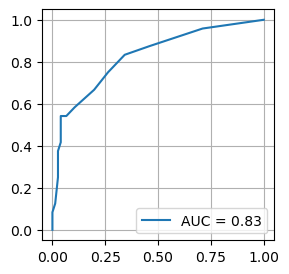

In [9]:
#  Одним действием получаем сразу три массива
FPR, TPR, p = sklm.roc_curve(y, y_pred)
# Вычисляем метрику AUC
auc = sklm.roc_auc_score(y, y_pred)

# Рисуем картинку
plt.figure(figsize = (3, 3))
plt.grid()
plt.plot(FPR, TPR, label = 'AUC = ' + str(round(auc, 2)))
plt.legend(loc = 'lower right')
# Сохраняем картинку с хорошим разрешением
# plt.savefig('ROC-кривая.png', dpi=300, bbox_inches='tight')
plt.show()

## Вычисление оптимального порога бинаризации

Площадь под желтой ломаной можно посчитать исходя из координат ее единственной вершины, координаты которой $({\rm TPR}_i, {\rm TPR}_i)$. Формула для этой площади такова:
$$
S = \frac{{\rm TPR}_i - {\rm TPR}_i + 1}{2}
$$
Это нетрудное упражение по элементарной геометрии. Эту формулу мы используем в цикле, чтобы выяснить, на каком пороге бинаризации метрика AUC оказывается наибольшей. 

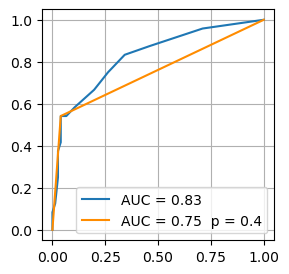

In [10]:
plt.figure(figsize = (3, 3))
plt.grid()

# Рисуем вероятностную ROC-кривую
plt.plot(FPR, TPR, label = 'AUC = ' + str(round(auc, 2)))

# Определяем, на каком номере массива p получается максимальное значение метрики AUC для бинарного прогноза
auc0 = 0
k = 0
for i in range(len(p)):
    if 0.5 * (TPR[i] - FPR[i] + 1) > auc0:
        auc0 = 0.5 * (TPR[i] - FPR[i] + 1)
        k = i

# Рисуем бинарную ROC-кривую с максимальной метрикой AUC
plt.plot([0, FPR[k], 1], [0, TPR[k], 1], '-', label = 'AUC = ' + str(round(auc0, 2)) + '  p = ' + str(round(p[k], 2)), 
         color = 'darkorange')

plt.legend(loc = 'lower right')
# plt.savefig('Повторный запуск.png', dpi=300, bbox_inches='tight')
plt.show()

### Повторный запуск

Делаем еще раз то же самое, но заново разделив данные на `train` и `test`. 

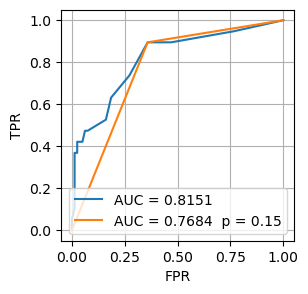

In [11]:
# Новое разбиение данных
df_train, df_test = sklearn.model_selection.train_test_split(df, train_size = 0.8, test_size = 0.2)#, random_state = 42)

# Заново строим и учим модель
X_train = df_train.drop(columns = ['Доля подписок']).to_numpy()
y_train = df_train['Доля подписок'].to_numpy()

X_test = df_test.drop(columns = ['Доля подписок']).to_numpy()
y_test = df_test['Доля подписок'].to_numpy()

model = skln.KNeighborsClassifier(20)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]

y = y_test

# Получаем данные для ROC-кривой
FPR, TPR, p = sklm.roc_curve(y, y_pred)
auc = sklm.roc_auc_score(y, y_pred)

# Определяем максимальное значение метрики AUC. Соответствующее значение p -- это оптимальный порго бинаризации
auc0 = 0
k = 0
for i in range(len(p)):
    if 0.5 * (TPR[i] - FPR[i] + 1) > auc0:
        auc0 = 0.5 * (TPR[i] - FPR[i] + 1)
        k = i
# Картинка        
plt.figure(figsize = (3, 3))
plt.grid()
# Вероятностная ROC-кривая
plt.plot(FPR, TPR, label = 'AUC = ' + str(round(auc, 4)))
plt.ylabel('TPR')
plt.xlabel('FPR')
# ROC-кривая после бинаризации по потимальному порогу 
plt.plot([0, FPR[k], 1], [0, TPR[k], 1], '-', label = 'AUC = ' + str(round(auc0, 4)) + '  p = ' + str(round(p[k], 4)))
plt.legend(loc = 'lower right')
plt.show()

Предыдущие два запуска дают, вообще говоря, разные значения метрики AUC и картинки тоже разные.

## Усреднение ROC-кривой на множестве запусков

А если провести не два запуска, а много, а потом все усреднить, то возникнет какая-то устойчивая ситуация, не подверженная случайным изменениям.

Здесь мы сначала заводим пустые списки, в которые потом в цикле будем заносить все  получающиеся сведения. Причем, следует иметь в виду, что FPR, TPR и P это массивы, а AUC это число. То есть, получается три списка массивов, которые мы потом усредняем и получаем три массива, и один список чисел, который мы потом усредняем и получаем одно число.

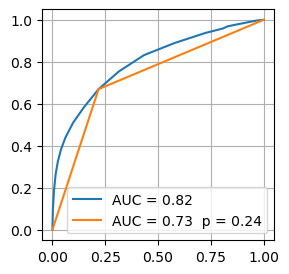

In [12]:
# Заводим пустые списки
FPR_list = []
TPR_list = []
AUC_list = []
p_list   = []

# В цикле выполняем все теже действия, что и выше: разбение на train и test и так далее
# Так как random_state отключен, разбиения все получаются разные
for i in range(1, 250):

    df_train, df_test = sklearn.model_selection.train_test_split(df, train_size = 0.8, test_size = 0.2)

    X_train = df_train.drop(columns = ['Доля подписок']).to_numpy()
    y_train = df_train['Доля подписок'].to_numpy()

    X_test = df_test.drop(columns = ['Доля подписок']).to_numpy()
    y_test = df_test['Доля подписок'].to_numpy()

    model = skln.KNeighborsClassifier(20)

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:, 1]

    y = y_test

    FPR, TPR, p = sklm.roc_curve(y, y_pred)
    auc = sklm.roc_auc_score(y, y_pred)
    
    # Аппендим полученные результаты в заготовленные спсики
    FPR_list.append(FPR)
    TPR_list.append(TPR)
    p_list.append(p)
    AUC_list.append(auc)

# Загоняем полученные списки массивов в дата-фреймы и считаем средние
FPR_df = pd.DataFrame(FPR_list)
FPR = FPR_df.mean().to_numpy()

TPR_df = pd.DataFrame(TPR_list)
TPR = TPR_df.mean().to_numpy()

p_df = pd.DataFrame(p_list)
p = p_df.mean().to_numpy()

# Загоняем список чисел в массив и считаем среднее
auc = np.array(AUC_list).mean()

plt.figure(figsize = (3, 3))
plt.grid()

# Рисуем усредненную вероятностную ROC-кривую. Она получается гладкой! Круто
plt.plot(FPR, TPR, label = 'AUC = ' + str(round(auc, 2)))

# Находим для вероятностной ROC-кривой оптимальный порог бинаризации
auc0 = 0
k = 0
for i in range(len(p)):
    if 0.5 * (TPR[i] - FPR[i] + 1) > auc0:
        auc0 = 0.5 * (TPR[i] - FPR[i] + 1)
        k = i

# Рисуем бинарную ROC-кривую
plt.plot([0, FPR[k], 1], [0, TPR[k], 1], '-', label = 'AUC = ' + str(round(auc0, 2)) + '  p = ' + str(round(p[k], 2)))

plt.legend(loc = 'lower right')
# plt.savefig('Усредненная бинаризация.png', dpi=300, bbox_inches='tight')
plt.show()

## Сравнение оптимизированного бинарного прогноза с дефолтным

Здесь мы просто два раза запускаем алгоритм сравнения метрики AUC (AUC на дефолтной бинаризации сравнивается с AUC на оптимизированной бинаризации) для того, чтобы показать, что случайные разбиения на `train` и `test`, дают вообще говоря, разные результаты.

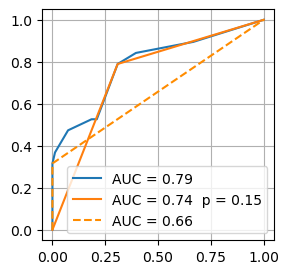

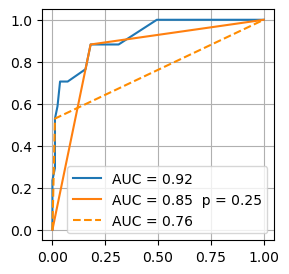

In [13]:
# Два независимых запуска, чтобы показать, что получаются разные кртинки
for j in range(2):

    df_train, df_test = sklearn.model_selection.train_test_split(df, train_size = 0.8, test_size = 0.2)#, random_state = 42)

    X_train = df_train.drop(columns = ['Доля подписок']).to_numpy()
    y_train = df_train['Доля подписок'].to_numpy()

    X_test = df_test.drop(columns = ['Доля подписок']).to_numpy()
    y_test = df_test['Доля подписок'].to_numpy()

    model = skln.KNeighborsClassifier(20)

    model.fit(X_train, y_train)
    
    # Зедсь мы строим вероятностное предсказание
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:, 1]

    # А здесь -- бинарное
    y_pred = model.predict(X_test)
    y = y_test

    # ROC-AUC для вероятностного прогноза
    FPR_proba, TPR_proba, p_proba = sklm.roc_curve(y, y_pred_proba)
    auc_proba = sklm.roc_auc_score(y, y_pred_proba)

    # ROC-AUC для бинарного прогноза
    FPR, TPR, p = sklm.roc_curve(y, y_pred)
    auc = sklm.roc_auc_score(y, y_pred)

    # Определение оптимальной бинаризации для вероятностного прогноза
    auc0_proba = 0
    k = 0
    for i in range(len(p_proba)):
        if 0.5 * (TPR_proba[i] - FPR_proba[i] + 1) > auc0_proba:
            auc0_proba = 0.5 * (TPR_proba[i] - FPR_proba[i] + 1)
            k = i

    plt.figure(figsize = (3, 3))
    plt.grid()
    
    # Вероятностная ROC-кривая
    plt.plot(FPR_proba, TPR_proba, label = 'AUC = ' + str(round(auc_proba, 2)))
    
    # Бинарная ROC-кривая с оптимальным порогом бинаризации
    plt.plot([0, FPR_proba[k], 1], [0, TPR_proba[k], 1], '-', 
             label = 'AUC = ' + str(round(auc0_proba, 2)) + '  p = ' + str(round(p_proba[k], 2)))

    # Бинарная ROC-кривая с дефолтным порогом бинаризации
    plt.plot(FPR, TPR, '--', 
             label = 'AUC = ' + str(round(auc, 2)), color = 'darkorange')

    plt.legend(loc = 'lower right')
    # plt.savefig('Обе метрики при ' + str(j) + ' запуске.png', dpi=300, bbox_inches='tight')
    plt.show()

## Сравнение на множестве запусков

И, наконец, делаем то же самое, но не 2 раза, а 250 раз. И все усредняем, чтобы стабилизировать результаты. 

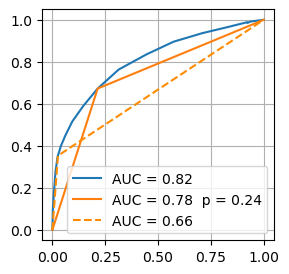

In [14]:
FPR_list = []
TPR_list = []
AUC_list = []
p_list   = []

FPR_list_proba = []
TPR_list_proba = []
AUC_list_proba = []
p_list_proba   = []

k_list = []

for i in range(250):

    df_train, df_test = sklearn.model_selection.train_test_split(df, train_size = 0.8, test_size = 0.2)#, random_state = 42)

    X_train = df_train.drop(columns = ['Доля подписок']).to_numpy()
    y_train = df_train['Доля подписок'].to_numpy()

    X_test = df_test.drop(columns = ['Доля подписок']).to_numpy()
    y_test = df_test['Доля подписок'].to_numpy()

    model = skln.KNeighborsClassifier(20)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:, 1]

    y_pred = model.predict(X_test)

    y = y_test
    
    FPR_proba, TPR_proba, p_proba = sklm.roc_curve(y, y_pred_proba)
    auc_proba = sklm.roc_auc_score(y, y_pred_proba)

    FPR, TPR, p = sklm.roc_curve(y, y_pred)
    auc = sklm.roc_auc_score(y, y_pred)
    
    FPR_list.append(FPR)
    TPR_list.append(TPR)
    p_list.append(p)
    AUC_list.append(auc)
    
    FPR_list_proba.append(FPR_proba)
    TPR_list_proba.append(TPR_proba)
    p_list_proba.append(p_proba)
    AUC_list_proba.append(auc_proba)

    auc0_proba = 0
    k = 0
    for i in range(len(p_proba)):
        if 0.5 * (TPR_proba[i] - FPR_proba[i] + 1) > auc0_proba:
            auc0_proba = 0.5 * (TPR_proba[i] - FPR_proba[i] + 1)
            k = i
    
    k_list.append(k)
    
FPR_df = pd.DataFrame(FPR_list)
FPR = FPR_df.mean().to_numpy()

TPR_df = pd.DataFrame(TPR_list)
TPR = TPR_df.mean().to_numpy()

p_df = pd.DataFrame(p_list)
p = p_df.mean().to_numpy()

auc = np.array(AUC_list).mean()

FPR_df_proba = pd.DataFrame(FPR_list_proba)
FPR_proba = FPR_df_proba.mean().to_numpy()

TPR_df_proba = pd.DataFrame(TPR_list_proba)
TPR_proba = TPR_df_proba.mean().to_numpy()

p_df_proba = pd.DataFrame(p_list_proba)
p_proba = p_df_proba.mean().to_numpy()

auc_proba = np.array(AUC_list_proba).mean()

k = int(round(np.array(k_list).mean(), 0))
            
plt.figure(figsize = (3, 3))
plt.grid()
plt.plot(FPR_proba, TPR_proba, label = 'AUC = ' + str(round(auc_proba, 2)))

plt.plot([0, FPR_proba[k], 1], [0, TPR_proba[k], 1], '-', 
         label = 'AUC = ' + str(round(auc0_proba, 2)) + '  p = ' + str(round(p_proba[k], 2)))


plt.plot(FPR, TPR, '--', 
         label = 'AUC = ' + str(round(auc, 2)), color = 'darkorange')

plt.legend(loc = 'lower right')
# plt.savefig('Обе метрики на множестве запусков.png', dpi=300, bbox_inches='tight')
plt.show()

В итоге оказывается, что оптимальный порог бинаризации (конкретно на этих данных) сильно отличается от дефолтного значения 0.5. И выбор порога бинаризации на уровне 0.23 дает большой прирост в точности прогноза (конкретно для этого метода, а мы использовали kNN). 